In [552]:
import numpy as np
import matplotlib.pyplot as plt

## Smoothing COVID data

So we'll see how a convolution works on real data.
We'll get the latest mortality figures from **GitHub**.

The [source](https://github.com/CSSEGISandData/COVID-19) is maintained by John Hopkins University.


In [553]:
! ../.g


[master 805b3b5] web
 3 files changed, 1410 insertions(+), 17 deletions(-)
 create mode 100644 PROG/.ipynb_checkpoints/uk-checkpoint.ipynb
 create mode 100644 PROG/uk.ipynb
Counting objects: 5, done.
Delta compression using up to 12 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 171.41 KiB | 3.43 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/macbuse/macbuse.github.io.git
   c2525cf..805b3b5  master -> master


In [517]:
import requests
import pandas as pd

In [518]:
root_dir = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
fn = 'time_series_covid19_%s_global.csv'

for ss in ['deaths','confirmed']:
    r = requests.get(root_dir + fn%ss, allow_redirects=True)
    open('covid_%s.csv'%ss, 'wb').write(r.content)

## Visualising the data again

We'll convert to a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

- If you want to know more [read this in french](http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_Data_Manipulation_Pandas.pdf).
- It's basically a table like in Excel
    - columns have names
    - rows are numbered and accessed using ```iloc```.


In [737]:
df = pd.read_csv('covid_deaths.csv')

---

## List the countries with > 10000 dead

In [744]:
 df[ df.iloc[:,-1] > 10000 ].iloc[:,[1,-1]]

,Country/Region,11/12/20
6,Argentina,34782
23,Belgium,13891
30,Brazil,164281
55,Chile,14699
89,Colombia,33491
106,Ecuador,12946
126,France,42215
130,Germany,12216
143,India,128668
144,Indonesia,14933


In [628]:
country = 258
df.iloc[country]

Province/State               NaN
Country/Region    United Kingdom
Lat                      55.3781
Long                      -3.436
1/22/20                        0
                       ...      
11/8/20                    49044
11/9/20                    49238
11/10/20                   49770
11/11/20                   50365
11/12/20                   50928
Name: 258, Length: 300, dtype: object

---

It's often easier to work with a numpy array of values

In [629]:
deaths = df.iloc[country][4:].values
deaths[-50:]

array([41902, 41936, 41971, 41988, 42001, 42072, 42143, 42202, 42268,
       42317, 42350, 42369, 42445, 42515, 42592, 42679, 42760, 42825,
       42875, 43018, 43155, 43293, 43429, 43579, 43646, 43726, 43967,
       44158, 44347, 44571, 44745, 44896, 44998, 45365, 45675, 45955,
       46229, 46555, 46717, 46853, 47250, 47742, 48120, 48475, 48888,
       49044, 49238, 49770, 50365, 50928], dtype=object)

# Cumulative deaths

this looks pretty smooth

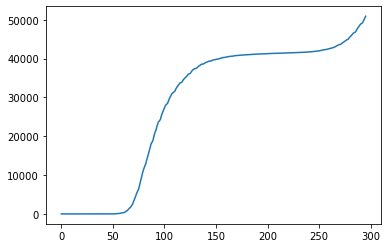

In [685]:
plt.plot(deaths);

Use ```np.diff``` to get daily death figures.

This is like differentiating the cumulative numbers.

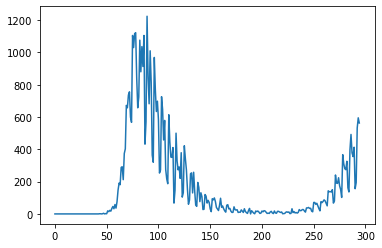

In [686]:
daily = np.diff(deaths,1)
plt.plot(daily);

Lets's look at the second wave

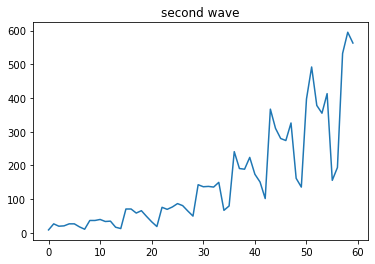

In [687]:
plt.plot(daily[-60:])
plt.title('second wave');

---

## Weekdays

The data is not too noisy compared with France.


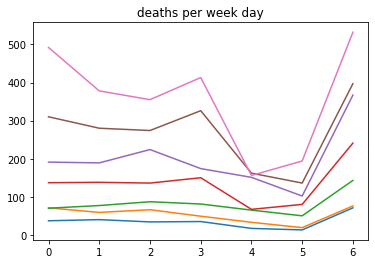

In [633]:
weeks = daily[-51:-2].reshape((-1,7))
for row in weeks:
    plt.plot(row)
    
plt.title('deaths per week day');

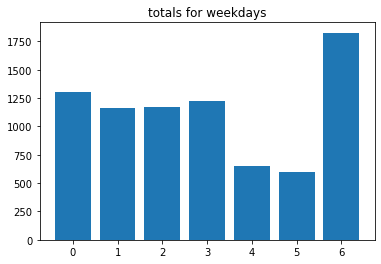

In [634]:
plt.bar(np.arange(7), np.sum(weeks, axis=0))
#plt.plot(np.sum(weeks, axis=0))
plt.title('totals for weekdays');

## Smoothing



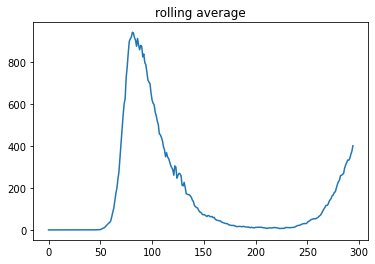

In [688]:
rolling_av = np.convolve(daily, np.ones(7)/7)[:-6]

plt.plot( rolling_av)
plt.title('rolling average');

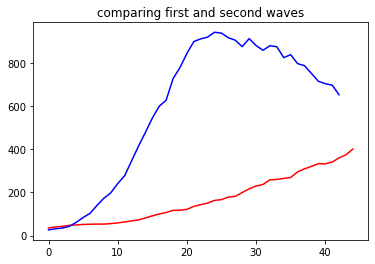

In [689]:
plt.plot(rolling_av[250:],'r')
plt.plot(rolling_av[57:100],'b');
plt.title('comparing first and second waves');

---

## Kind of dumb but..

This is a heat map of the rvalue
to see where the fit is best.

<ipython-input-710-192081de6ef9>:2: RuntimeWarning: divide by zero encountered in log
  YY = np.log(rolling_av.tolist())


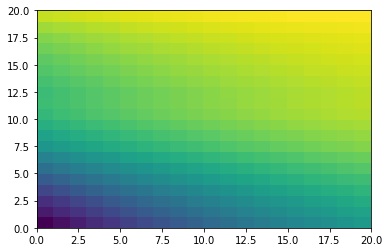

In [710]:
M = np.zeros((20,20))
YY = np.log(rolling_av.tolist())

for i, x in enumerate(range(200,220)):
    for j, y in enumerate(range(275,295)):
        Y = YY[x:y]
        X = np.arange(y-x)
        M[i,j] = stats.linregress(X,Y).rvalue
        
plt.pcolor(M)
plt.show()

# Exponential  growth in deaths ?

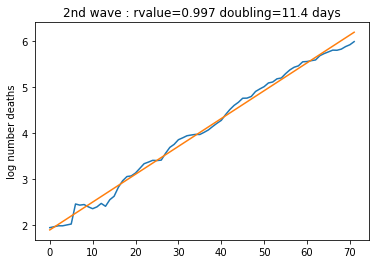

In [713]:
from scipy import stats

Y =  np.log(rolling_av[223:].tolist())
X = np.arange(len(Y))

#plot raw data
plt.plot(X,Y);

#do regression
coeffs = stats.linregress(X,Y)
a,b = coeffs.slope, coeffs.intercept

#plot regression curve
plt.plot( X[[0,-1]], a*X[[0,-1]] + b)
plt.title('2nd wave : rvalue={:.3f} doubling={:.1f} days'.format(coeffs.rvalue, np.log(2)/a) )
plt.ylabel('log number deaths');
    

---

## That's great!!


The exponential factor is smaller for the UK 
and the [doubling time](https://en.wikipedia.org/wiki/Doubling_time) is about 12 days !

This is still in the region of the incubation period for COVID.


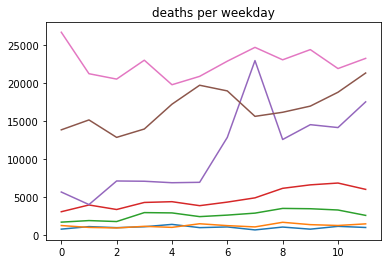

In [650]:
weeks = daily[200:-11].reshape((-1,12))
for row in weeks:
    plt.plot(row)
    
plt.title('deaths per weekday');

---

## Confirmed cases

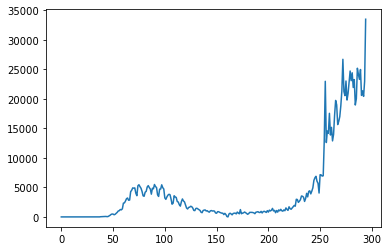

In [641]:
df = pd.read_csv('covid_confirmed.csv')

cases =  df.iloc[country][4:].values
daily = np.diff(cases, 1)
plt.plot(daily);

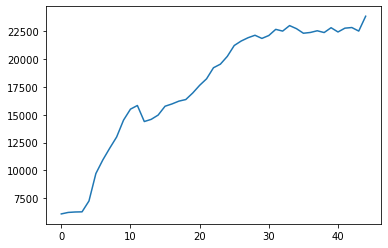

In [642]:
smoothed = np.convolve(daily, np.ones(7)/7)[:-6]
plt.plot(smoothed[250:]);

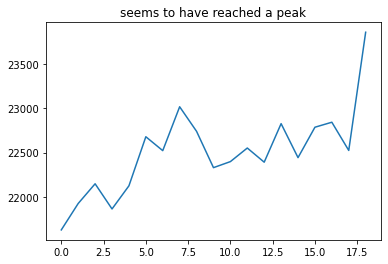

In [644]:

smoothed = np.convolve(daily, np.ones(7)/7)
plt.plot(smoothed[-25:-6]);
plt.title('seems to have reached a peak');

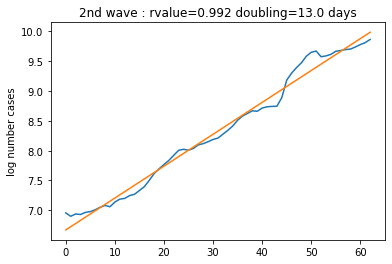

In [714]:
Y = smoothed[210:273].tolist()
X = np.arange(len(Y))

Y = np.log(Y)
plt.plot(X,Y)

coeffs = stats.linregress(X,Y)
a,b = coeffs.slope, coeffs.intercept

plt.plot( X[[0,-1]], a*X[[0,-1]] + b)
plt.title('2nd wave : rvalue={:.3} doubling={:.1f} days'.format(coeffs.rvalue, np.log(2)/a) )

plt.ylabel('log number cases');

In [606]:
np.log(2)

0.6931471805599453

# Mortality rate for the second wave

In [716]:
(deaths[-1] - deaths[210])/ (cases[-1] - cases[210])

0.00983492880485648

In [666]:
M = np.zeros((20,20))
YY = np.log(smoothed.tolist())

for i, x in enumerate(range(200,220)):
    for j, y in enumerate(range(270,290)):
        Y = YY[x:y]
        X = np.arange(y-x)
        M[i,j] = stats.linregress(X,Y).rvalue

<ipython-input-666-49efe0b4dab3>:2: RuntimeWarning: divide by zero encountered in log
  YY = np.log(smoothed.tolist())


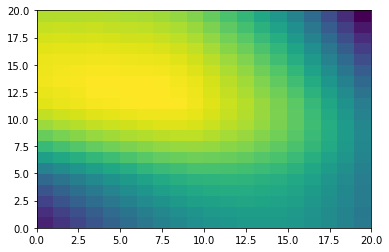

In [678]:
plt.pcolor(M)
plt.show()

In [718]:
! ../.g 

[master a8ba0be] web
 1 file changed, 74 insertions(+), 230 deletions(-)
Counting objects: 4, done.
Delta compression using up to 12 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 37.32 KiB | 6.22 MiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/macbuse/macbuse.github.io.git
   21796ee..a8ba0be  master -> master
